# Libraries

In [1]:
import numpy as np
import pandas as pd
import pickle
import tqdm.auto as tqdm
from pprint import pprint
import collections
import random
import feather
from sklearn import metrics

# Use restricted_wcc dataset (only courses from WCC, no summer, keep only row from last five years or from a student with a course in the last five years) from wrangling_restricted_wcc_dataset.ipynb

In [2]:
WCC_PD_PATH = "../data/wcc_pd.pkl"

with open(WCC_PD_PATH, "rb") as file:
    raw_data = pickle.load(file)
    
raw_data

,acad_career,strm,stdnt_enrl_status,unt_taken,unt_billing,crse_grade_input,earn_credit,emplid,subject,catalog_nbr,crse_acad_org,sex,gpa,grade_points,total_units,cum_grade_points,cum_units,overall_gpa,prior_term_gpa,course_name
0,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,MATH,51,MATH,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,MATH51
2,UG,1182.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,31X,CHEMISTRY,M,4.0,72.0,18.0,72.0,18.0,4.000000,NaN,CHEM31X
4,UG,1184.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CS,106X,COMPUTSCI,M,4.0,65.1,17.0,137.1,35.0,3.917143,4.000000,CS106X
5,UG,1184.0,E,5.0,5.0,B+,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,CHEM,33,CHEMISTRY,M,3.3,65.1,17.0,137.1,35.0,3.917143,4.000000,CHEM33
7,UG,1184.0,E,5.0,5.0,A,Y,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,PHIL,1,PHILOSOPHY,M,4.0,65.1,17.0,137.1,35.0,3.917143,4.000000,PHIL1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784334,UG,1202.0,E,5.0,5.0,B+,Y,zYPvt/OnDJZcB1qpg0uKI7zFYa5srO2CCsIU8VsIDeWYy+...,PSYCH,1,PSYCHOLOGY,F,3.3,51.1,17.0,187.3,58.0,3.229310,3.321951,PSYCH1
784339,UG,1192.0,E,5.0,5.0,A,Y,zYZXgYeShvA/cD8TzNRRLxzbAblBrpRdc8KW5geNAtn0Px...,PSYCH,1,PSYCHOLOGY,F,4.0,60.0,15.0,60.0,15.0,4.000000,NaN,PSYCH1
784340,UG,1196.0,E,5.0,5.0,B+,Y,zYZXgYeShvA/cD8TzNRRLxzbAblBrpRdc8KW5geNAtn0Px...,STATS,60,STATISTICS,F,3.3,69.7,18.0,184.2,47.0,3.919149,3.948276,STATS60
784342,UG,1202.0,E,6.0,6.0,B-,Y,zz5j89pAbihrd+eaiLAddrxwyMh4sbs5K1W8uNxhwe5ome...,CME,100A,ICME,M,2.7,33.7,11.0,33.7,11.0,3.063636,NaN,CME100A


In [3]:
all_courses = set(raw_data["course_name"])
# pprint(all_courses)
# print(len(all_courses))

In [4]:
# descriptive statistics
print(len(raw_data), "unique course records")
print(len(raw_data["emplid"].unique()), "unique students")
print(len(raw_data["course_name"].unique()), "unique courses")

166194 unique course records
13218 unique students
878 unique courses


In [5]:
OFFICIAL_PREREQ_PATH = "../data/official_reqs.pkl"

with open(OFFICIAL_PREREQ_PATH, "rb") as file:
    official_prereqs = pickle.load(file)
    
pprint(official_prereqs["CS110"])
pprint(official_prereqs["CS221"])
# pprint(official_prereqs)

['CS107']
['CS103', 'CS106B', 'CS106X', 'CS107', 'CS109']


In [6]:
def getTargetGPAColumn(gpaString):
    gpaString = str(gpaString)
    gpaString = gpaString.lower()
    if gpaString == "nan":
        return "gpa_NaN"
    gpaValue = float(gpaString)
    if gpaValue > 3.7:
        return "gpa_A"
    elif gpaValue > 2.7:
        return "gpa_B"
    elif gpaValue > 1.7:
        return "gpa_C"
    elif gpaValue > 0.7:
        return "gpa_D"
    else:
        return "gpa_NP"

In [7]:
# Builds the feature matrix X and output vector y for a given course, using all other courses in the dataset
# as possible predictors. Only adds a column for another course if at least one student has taken that other
# course before the given course.
# Set gender = True to also add a prediction vector for female (0/1).
# Returns a dataframe with y appended to the right of X, split them off later in get_and_split_data().
############################################################################################################
# 2020-02-23 Initial model settings: 
# Predict success in a course (B+ or better) based on having passed other courses previously (D- or better)
# Incomplete data for strm 1204 (2019-2020 Winter)
# Only consider courses taken at or after strm 1162 (2015-2016 Autumn)
# Y1GRADES = ["A+", "A", "A-", "B+"]
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"]
# UNFINISHED_QUARTERS = [1204]
# CUTOFF_QUARTER = 1162

# Y1GRADES = ["A+", "A", "A-", "B+"] # we encode these grades as y = 1, otherwise y = 0
# X1GRADES = ["A+", "A", "A-", "B+", "B", "B-", 
#             "C+", "C", "C-", "D+", "D", "D-"] # for previous courses, encode these grades as X_i = 1
UNFINISHED_QUARTERS = [1204] # unfinished quarter(s) if pulled during a quarter
CUTOFF_QUARTER = 1162

# added x1param and y1param as optional parameters, use these or custom lists
LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
SUCCESS_GRADES = ["A+", "A", "A-", "B+"]

def getStudentFeatures(target_course, gender = False, gpa = False, prereqSuccess = False,
                       x1param = PASS_GRADES, y1param = SUCCESS_GRADES, prereqs = False):
    if prereqSuccess:
        x1param = SUCCESS_GRADES
    course_entries = raw_data.loc[(raw_data['course_name'] == target_course) & # all course entries that are about the certain course we want
                                  (raw_data['crse_grade_input'].isin(LETTER_GRADES)) & # Grade needs to be a letter
                                  (raw_data['stdnt_enrl_status'] != 'D') & # not dropped
                                  (raw_data['strm'] >= CUTOFF_QUARTER) & # target (outcome) course during or after the cutoff
                                  (~raw_data['strm'].isin(UNFINISHED_QUARTERS))] # we don't have outcomes for these
    students = course_entries.emplid # Students from the course entries
    students_prev_classes = raw_data.loc[raw_data['emplid'].isin(students)] # Other classes taken by these students
    possible_prev_classes = students_prev_classes['course_name'].unique().tolist() # List of courses taken by these students
    possible_prev_classes.append("strm") # For now add term to the data of when the course was taken
    if gender:
        possible_prev_classes.append("female") # Add gender
    if gpa: # Add GPA
        possible_prev_classes.append("gpa_A")
        possible_prev_classes.append("gpa_B")
        possible_prev_classes.append("gpa_C")
        possible_prev_classes.append("gpa_D")
        possible_prev_classes.append("gpa_NP")
        possible_prev_classes.append("gpa_NaN")
    possible_prev_classes.append("emplid") # Add emplid
    possible_prev_classes.append("y") # Add the target to the data. Will split it later
    a = np.zeros(shape = (len(course_entries), len(possible_prev_classes))) # all 0 initialized features matrix
    full_matrix = pd.DataFrame(a, columns = possible_prev_classes) # same as above, but in pandas to allow indexing by course name
    for counter, idx in enumerate(course_entries.index): # loop over all class entries
        grade = course_entries.loc[[idx]]['crse_grade_input']
        gradeStr = grade.tolist()[0]
        if (gradeStr in y1param):
            full_matrix.iloc[counter, full_matrix.columns.get_loc("y")] = 1
        # fill predictor matrix X
        std_id = course_entries.loc[[idx]]['emplid'] # Get the student id
        quarter = course_entries.loc[[idx]]['strm'] # Get the term
        student_courses = students_prev_classes.loc[students_prev_classes['emplid'] == std_id.tolist()[0]] # Get all courses the student took
        student_courses = student_courses.loc[student_courses['strm'] < quarter.tolist()[0]] # Filter the courses to be only before the course of interest
        if gender:
            female = course_entries.loc[[idx]]['sex'] # Get the student gender
            if (female.tolist()[0] == 'M'):
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 0
            else:
                full_matrix.iloc[counter, full_matrix.columns.get_loc("female")] = 1
        if gpa:
            prior_GPA = course_entries.loc[[idx]]['prior_term_gpa'] # Get the student's GPA for the previous term
            full_matrix.iloc[counter, full_matrix.columns.get_loc(getTargetGPAColumn(prior_GPA.tolist()[0]))] = 1
        full_matrix.iloc[counter, full_matrix.columns.get_loc("strm")] = quarter.tolist()[0]
        full_matrix.iloc[counter, full_matrix.columns.get_loc("emplid")] = std_id.tolist()[0]
        for j in student_courses.index:# Loop over the student's courses
            course_name = student_courses.loc[[j]]['subject']+student_courses.loc[[j]]['catalog_nbr'] # Get the course name
            grade = student_courses.loc[[j]]['crse_grade_input']
            gradeStr = grade.tolist()[0]
            if (gradeStr in x1param):
                full_matrix.iloc[counter, full_matrix.columns.get_loc(course_name.tolist()[0])] = 1 # Set the course name in X to the new value (or if it was already passed keep the value)
    if not prereqs:
        return full_matrix
    
    # compute prereq_matrix with official prereq pickle
    prereq_columns = official_prereqs[target_course] + ['strm', 'emplid', 'y']
    if gender:
        prereq_columns.extend(['female'])
    if gpa:
        prereq_columns.extend(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'])
    prereq_matrix = full_matrix[prereq_columns]
    return full_matrix, prereq_matrix

In [8]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = PASS_GRADES, y1param = PASS_GRADES)
features_cs110_testparams

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,1.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [9]:
features_cs110_testparams = getStudentFeatures('CS110', x1param = SUCCESS_GRADES, y1param = SUCCESS_GRADES)
features_cs110_testparams

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [10]:
full_cs110, prereqs_cs110 = getStudentFeatures("CS110", prereqs = True)

In [11]:
full_cs110

,MATH51,CHEM31X,CS106X,CHEM33,PHIL1,CS103,CHEM35,CS109,CS161,CS107,...,PHYSICS230,PHYSICS231,BIO153,MATH220,PHYSICS62,ME105,AA272C,strm,emplid,y
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


In [12]:
prereqs_cs110

,CS107,strm,emplid,y
0,1.0,1202.0,$2a$15$.iQPCHeeuyLD3TIqJRk4j.LU0IjGYumSdFkAEUf...,1.0
1,1.0,1192.0,$2a$15$5tXEOl2owViV9E5K1pJ/Luf.44w/Ci69ZBbFT6o...,1.0
2,1.0,1186.0,$2a$15$aHTw2jbPTbRKGeDBfcQ25.KPs1kJF/UqcPukXAC...,0.0
3,0.0,1194.0,$2a$15$CgRoc5cbNZ0QTWMIqNSbu..3w/a0GkYDa3ktG1x...,1.0
4,1.0,1186.0,$2a$15$Ejn9P.vrIOxTGiqTGICiDeLirjfUfjv4xBdI4h6...,0.0
...,...,...,...,...
1534,1.0,1202.0,YUqcVvVPHekQ3pk5dsZJb91EacfOFwSq9yrH4Gab7GbT8O...,1.0
1535,1.0,1196.0,YX37GM6UxzX5a19UpwoQ6J4bq4x6Obi/zOIjqRmAfPWmBc...,1.0
1536,1.0,1194.0,zeMsirklPKg0Ts2/jhhHTE4QTDubdJ6VAh420a2SxyZdWj...,1.0
1537,1.0,1202.0,zmNzWWYP45nMMEl7vSBuaNnqWtUycLozveGSKlGoXanF8B...,1.0


# Logistic regression models

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [14]:
UNSEEN_QUARTERS = [1204]
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters

def get_and_split_data_double_matrix(target_course, test_quarters = TEST_QUARTERS,
                                     gender = False, gpa = False, x1param = PASS_GRADES,
                                     y1param = SUCCESS_GRADES, random_seed = 42, dev = True):
    dataset_full, dataset_prereq = getStudentFeatures(target_course, gender = gender, gpa = gpa, x1param = x1param, y1param = y1param, prereqs = True)
    
    # process full dataset
    # data split for full
    dataset_grades_full = dataset_full.loc[~dataset_full['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_full = None
    if random_seed != None:
        if dev: # 80/10/10 split train/dev/test
            dataset_train_full, dataset_dev_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_full)), int(.9*len(dataset_grades_full))])
        else: # 85/15 split train/test
            dataset_train_full, dataset_test_full = np.split(dataset_grades_full.sample(frac=1, random_state=random_seed), [int(.85*len(ddataset_grades_full))])
    else:
        dataset_train_full = dataset_grades_full.loc[~dataset_grades_full['strm'].isin(test_quarters)]
        dataset_test_full = dataset_grades_full.loc[dataset_grades_full['strm'].isin(test_quarters)]
        if dev:
            dataset_train_full, dataset_dev_full = np.split(dataset_train_full.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_full))])

    # test students full df
    test_students_full = pd.DataFrame(list(dataset_test_full["emplid"]), columns = ["emplid"])
    if gender:
        test_students_full["female"] = list(dataset_test_full["female"])
    if gpa:
        test_students_full["gpa_A"] = list(dataset_test_full["gpa_A"])
        test_students_full["gpa_B"] = list(dataset_test_full["gpa_B"])
        test_students_full["gpa_C"] = list(dataset_test_full["gpa_C"])
        test_students_full["gpa_D"] = list(dataset_test_full["gpa_D"])
        test_students_full["gpa_NP"] = list(dataset_test_full["gpa_NP"])
        test_students_full["gpa_NaN"] = list(dataset_test_full["gpa_NaN"])
        
    # dev students full df
    
    if dev:
        dev_students_full = pd.DataFrame(list(dataset_dev_full["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_full["female"] = list(dataset_dev_full["female"])
        if gpa:
            dev_students_full["gpa_A"] = list(dataset_dev_full["gpa_A"])
            dev_students_full["gpa_B"] = list(dataset_dev_full["gpa_B"])
            dev_students_full["gpa_C"] = list(dataset_dev_full["gpa_C"])
            dev_students_full["gpa_D"] = list(dataset_dev_full["gpa_D"])
            dev_students_full["gpa_NP"] = list(dataset_dev_full["gpa_NP"])
            dev_students_full["gpa_NaN"] = list(dataset_dev_full["gpa_NaN"])
    else:
        dev_students_full = None
        
    # Prepare for X and Y for full
    dataset_train_full = dataset_train_full.drop(["strm", "emplid"], axis=1)
    dataset_test_full = dataset_test_full.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_full = dataset_dev_full.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_full = None

    # Build X and Y for full
    X_train_full = dataset_train_full.drop(["y"], axis=1)
    y_train_full = dataset_train_full["y"]
    X_test_full = dataset_test_full.drop(["y"], axis=1)
    y_test_full = dataset_test_full["y"]
    X_dev_full = None
    y_dev_full = None
    if dev:
        X_dev_full = dataset_dev_full.drop(["y"], axis=1)
        y_dev_full = dataset_dev_full["y"]
    
    if not len(X_train_full) or not len(X_test_full) or not len(y_train_full) or not len(y_test_full):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    # process official prereq dataset
    # data split for prereq
    dataset_grades_prereq = dataset_prereq.loc[~dataset_prereq['strm'].isin(UNSEEN_QUARTERS)] #For now, dropping this quarter
    dataset_dev_prereq = None
    if random_seed != None:
        if dev:
            dataset_train_prereq, dataset_dev_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.8*len(dataset_grades_prereq)), int(.9*len(dataset_grades_prereq))])
        else:
            dataset_train_prereq, dataset_test_prereq = np.split(dataset_grades_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_grades_prereq))])
    else:
        dataset_train_prereq = dataset_grades_prereq.loc[~dataset_grades_prereq['strm'].isin(test_quarters)]
        dataset_test_prereq = dataset_grades_prereq.loc[dataset_grades_prereq['strm'].isin(test_quarters)]
        if dev:
            dataset_train_prereq, dataset_dev_prereq = np.split(dataset_train_prereq.sample(frac=1, random_state=random_seed), [int(.85*len(dataset_train_prereq))])
        
    # test students prereq df
    test_students_prereq = pd.DataFrame(list(dataset_test_prereq["emplid"]), columns = ["emplid"])
    if gender:
        test_students_prereq["female"] = list(dataset_test_prereq["female"])
    if gpa:
        test_students_prereq["gpa_A"] = list(dataset_test_prereq["gpa_A"])
        test_students_prereq["gpa_B"] = list(dataset_test_prereq["gpa_B"])
        test_students_prereq["gpa_C"] = list(dataset_test_prereq["gpa_C"])
        test_students_prereq["gpa_D"] = list(dataset_test_prereq["gpa_D"])
        test_students_prereq["gpa_NP"] = list(dataset_test_prereq["gpa_NP"])
        test_students_prereq["gpa_NaN"] = list(dataset_test_prereq["gpa_NaN"])
    
    # dev students prereq df
    dev_students_prereq = None
    if dev:
        dev_students_prereq = pd.DataFrame(list(dataset_dev_prereq["emplid"]), columns = ["emplid"])
        if gender:
            dev_students_prereq["female"] = list(dataset_dev_prereq["female"])
        if gpa:
            dev_students_prereq["gpa_A"] = list(dataset_dev_prereq["gpa_A"])
            dev_students_prereq["gpa_B"] = list(dataset_dev_prereq["gpa_B"])
            dev_students_prereq["gpa_C"] = list(dataset_dev_prereq["gpa_C"])
            dev_students_prereq["gpa_D"] = list(dataset_dev_prereq["gpa_D"])
            dev_students_prereq["gpa_NP"] = list(dataset_dev_prereq["gpa_NP"])
            dev_students_prereq["gpa_NaN"] = list(dataset_dev_prereq["gpa_NaN"])
        
        
    dataset_train_prereq = dataset_train_prereq.drop(["strm", "emplid"], axis=1)
    dataset_test_prereq = dataset_test_prereq.drop(["strm", "emplid"], axis=1)
    if dev:
        dataset_dev_prereq = dataset_dev_prereq.drop(["strm", "emplid"], axis=1)
    else:
        dataset_dev_prereq = None

    X_train_prereq = dataset_train_prereq.drop(["y"], axis=1)
    y_train_prereq = dataset_train_prereq["y"]
    X_test_prereq = dataset_test_prereq.drop(["y"], axis=1)
    y_test_prereq = dataset_test_prereq["y"]
    if dev:
        X_dev_prereq = dataset_dev_prereq.drop(["y"], axis=1)
        y_dev_prereq = dataset_dev_prereq["y"]
    else:
        X_dev_prereq = None
        y_dev_prereq = None
    if not len(X_train_prereq) or not len(X_test_prereq) or not len(y_train_prereq) or not len(y_test_prereq):
        return (None, None, None, None, None, None, None, None, True), (None, None, None, None, None, None, None, None, True)
    
    return [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, False], [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, False]



In [15]:
# Use the X predictor matrix and y outcome vector from 
# getStudentFeatures, fit a logistic regression model and return
# the list of coefficients, default sorted by absolute value

# Params: sort = ["pos", "neg", "abs"] to sort by largest positive, negative, or
# absolute value of coefficients
def get_coefs_from_split(X_train, X_test, y_train, y_test, X_dev = None, y_dev = None, 
                         penalty='none', C=1.0, fail_flag = False, sort = "pos", solver = 'lbfgs'):
    if fail_flag:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    if len(y_train.unique()) == 1:
        return None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, True
    model = LogisticRegression(C=C, penalty=penalty, solver = solver, max_iter = 1000)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_score = model.score(X_dev, y_dev)
    else:
        dev_score = None
    test_score = model.score(X_test, y_test)
    
    train_groundtruth = y_train.mean()
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_groundtruth = y_dev.mean()
    else:
        dev_groundtruth = None
    test_groundtruth = y_test.mean()
    
    train_size = len(y_train)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_size = len(y_dev)
    else:
        dev_size = None
    test_size = len(y_test)
    
    y_test_predict = model.predict(X_test)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_predict = model.predict(X_dev)
    else:
        y_dev_predict = None
    
    prob_1_index = 1
    if model.classes_[1] != 1:
        prob_1_index = 0
    y_test_prob = [x[prob_1_index] for x in model.predict_proba(X_test)]
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        y_dev_prob = [x[prob_1_index] for x in model.predict_proba(X_dev)]
    else:
        y_dev_prob = None
    
    test_scores = precision_recall_fscore_support(y_test, y_test_predict, average = "binary", zero_division = 0)
    if str(type(X_dev)) != "<class 'NoneType'>" and str(type(y_dev)) != "<class 'NoneType'>":
        dev_scores = precision_recall_fscore_support(y_dev, y_dev_predict, average = "binary", zero_division = 0)
    else:
        dev_scores = None
    
    coefs = [(X_test.columns[i], model.coef_[0][i]) for i in range(len(X_test.columns))]
    if sort:
        if sort == "pos":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = True)
        if sort == "neg":
            coefs = sorted(coefs, key = lambda x: x[1], reverse = False)
        if sort == "abs":
            coefs = sorted(coefs, key = lambda x: abs(x[1]), reverse = True)
    return coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
            train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
            train_size, test_size, dev_size, test_scores, dev_scores, False



# Loop through all courses

In [16]:
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]

def run_predictions_with_prereqs(course_name, cache_name, results_full, results_prereq, full_coefs, prereq_coefs, test_quarters = TEST_QUARTERS,
                                 gender = False, gpa = False, x1param = PASS_GRADES, y1param = SUCCESS_GRADES,
                                 dev = True, penalty='l2', C=1.0, random_seed=42, solver = 'lbfgs'):
    [X_train_full_unfiltered, X_test_full_unfiltered, X_dev_full_unfiltered, y_dev_full, y_train_full, y_test_full, test_students_full_unfiltered, dev_students_full_unfiltered, fail_flag_full], \
    [X_train_prereq_unfiltered, X_test_prereq_unfiltered, X_dev_prereq_unfiltered, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq_unfiltered, dev_students_prereq_unfiltered, fail_flag_prereq] = \
        cache_name[course_name]
    
    if gpa and gender:
        X_train_full = X_train_full_unfiltered
        X_test_full = X_test_full_unfiltered
        X_dev_full = X_dev_full_unfiltered
        test_students_full = test_students_full_unfiltered
        dev_students_full = dev_students_full_unfiltered
        
        X_train_prereq = X_train_prereq_unfiltered
        X_test_prereq = X_test_prereq_unfiltered
        X_dev_prereq = X_dev_prereq_unfiltered
        test_students_prereq = test_students_prereq_unfiltered
        dev_students_prereq = dev_students_prereq_unfiltered
    elif not gpa and gender:
        X_train_full = X_train_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        X_test_full = X_test_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        X_dev_full = X_dev_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        test_students_full = test_students_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        dev_students_full = dev_students_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        
        X_train_prereq = X_train_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        X_test_prereq = X_test_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        X_dev_prereq = X_dev_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        test_students_prereq = test_students_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
        dev_students_prereq = dev_students_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN'], axis=1)
    elif not gender and gpa:
        X_train_full = X_train_full_unfiltered.drop(['female'], axis=1)
        X_test_full = X_test_full_unfiltered.drop(['female'], axis=1)
        X_dev_full = X_dev_full_unfiltered.drop(['female'], axis=1)
        test_students_full = test_students_full_unfiltered.drop(['female'], axis=1)
        dev_students_full = dev_students_full_unfiltered.drop(['female'], axis=1)
        
        X_train_prereq = X_train_prereq_unfiltered.drop(['female'], axis=1)
        X_test_prereq = X_test_prereq_unfiltered.drop(['female'], axis=1)
        X_dev_prereq = X_dev_prereq_unfiltered.drop(['female'], axis=1)
        test_students_prereq = test_students_prereq_unfiltered.drop(['female'], axis=1)
        dev_students_prereq = dev_students_prereq_unfiltered.drop(['female'], axis=1)
    else:
        X_train_full = X_train_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        X_test_full = X_test_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        X_dev_full = X_dev_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        test_students_full = test_students_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        dev_students_full = dev_students_full_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        
        X_train_prereq = X_train_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        X_test_prereq = X_test_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        X_dev_prereq = X_dev_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        test_students_prereq = test_students_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
        dev_students_prereq = dev_students_prereq_unfiltered.drop(['gpa_A', 'gpa_B', 'gpa_C', 'gpa_D', 'gpa_NP', 'gpa_NaN', 'female'], axis=1)
    
        
    # full results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_full, X_test_full, y_train_full, y_test_full,
                                                                                            X_dev=X_dev_full, y_dev=y_dev_full, penalty=penalty, C=C, 
                                                                                            solver = solver, fail_flag=fail_flag_full)
    
    test_students_full[course_name + "_y"] = list(y_test_full)
    test_students_full[course_name + "_y_predict"] = y_test_predict
    test_students_full[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_full[course_name + "_y"] = list(y_dev_full)
        dev_students_full[course_name + "_y_predict"] = y_dev_predict
        dev_students_full[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_full, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_full, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='lightpink', alpha=0.5)
    
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_full.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None, None])
    full_coefs[course_name] = dict(coefs)

    # official prereq results
    coefs, y_test_predict, y_test_prob, y_dev_predict, y_dev_prob, \
    train_score, test_score, dev_score, train_groundtruth, test_groundtruth, dev_groundtruth, \
    train_size, test_size, dev_size, test_scores, dev_scores, fail_flag = get_coefs_from_split(X_train_prereq, X_test_prereq, y_train_prereq, 
                                                                                            y_test_prereq, X_dev=X_dev_prereq, y_dev=y_dev_prereq, 
                                                                                            penalty=penalty, C=C, solver = solver, fail_flag=fail_flag_prereq)
    
    test_students_prereq[course_name + "_y"] = list(y_test_prereq)
    test_students_prereq[course_name + "_y_predict"] = y_test_predict
    test_students_prereq[course_name + "_y_prob"] = y_test_prob
    
    if dev:
        dev_students_prereq[course_name + "_y"] = list(y_dev_prereq)
        dev_students_prereq[course_name + "_y_predict"] = y_dev_predict
        dev_students_prereq[course_name + "_y_prob"] = y_dev_prob
        
        fpr, tpr, thresh = metrics.roc_curve(y_dev_prereq, y_dev_prob)
        auc = metrics.roc_auc_score(y_dev_prereq, y_dev_prob)
#         plt.plot(fpr,tpr,label="data "+course_name+"_full, auc="+str(auc), color='paleturquoise', alpha=0.5)
    
    
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], dev_scores[0], dev_scores[1], dev_scores[2], fpr, tpr, thresh, auc])
    else:
        results_prereq.append([course_name, train_score, test_score, dev_score, train_groundtruth, test_groundtruth, 
                         dev_groundtruth, train_size, test_size, dev_size, test_scores[0], test_scores[1],
                         test_scores[2], None, None, None, None, None, None, None])
    prereq_coefs[course_name] = dict(coefs)

In [17]:
# results_full = []
# results_prereq = []
# full_coefs = {}
# prereq_coefs = {}

# run_predictions_with_prereqs("CS221", results_full, results_prereq, full_coefs, prereq_coefs, gpa=True)
# results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
# results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)
# full_coefs_df = pd.DataFrame.from_dict(full_coefs, orient='index')
# prereq_coefs_df = pd.DataFrame.from_dict(prereq_coefs, orient='index')

In [18]:
# results_full_df

In [19]:
# results_prereq_df # better results than full model on test_score, suggests overfitting, but it's unregularized??
# # it's just predicting pass for everything, recall is 1.0 and precision is same as ground truth

In [20]:
# full_coefs_df

In [21]:
# prereq_coefs_df

In [22]:
# # test run with random seed and dev set

# results_full = []
# results_prereq = []
# full_coefs = {}
# prereq_coefs = {}

# run_predictions_with_prereqs("CS221", results_full, results_prereq, full_coefs, prereq_coefs)
# results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
# results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)
# full_coefs_df = pd.DataFrame.from_dict(full_coefs, orient='index')
# prereq_coefs_df = pd.DataFrame.from_dict(prereq_coefs, orient='index')

In [23]:
# results_full_df

In [24]:
# results_prereq_df

In [25]:
# full_coefs_df

In [26]:
# prereq_coefs_df

## compute and plot ROC

In [27]:
from scipy import interp
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from matplotlib import rc

def plot_roc(full_results, prereq_results, pathname, plot_title):
    rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    ## for Palatino and other serif fonts use:
    #rc('font',**{'family':'serif','serif':['Palatino']})
    rc('text', usetex=True)
    
    plt.figure(0, figsize=(6, 6), dpi=150).clf()
    
    fpr_pos = len(full_results[0]) - 4
    tpr_pos = len(full_results[0]) - 3
    auc_pos = len(full_results[0]) - 1
    fpr = []
    tpr = []
    for i in range(len(full_results)):
        course_data = full_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='lightcoral', alpha=0.035)
    
    # Plot macro average for full
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(full_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(full_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(full_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average for detected prep. model, auc="+"{:.4f}".format(roc_auc_macro), color='lightcoral', alpha=1)
    
    fpr = []
    tpr = []
    for i in range(len(prereq_results)):
        course_data = prereq_results[i]
        fpr_i = course_data[fpr_pos]
        tpr_i = course_data[tpr_pos]
        auc_i = course_data[auc_pos]
        fpr.append(fpr_i)
        tpr.append(tpr_i)
        plt.plot(fpr_i,tpr_i, color='dodgerblue', alpha=0.03)

    # Plot macro average for prereq
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(prereq_results))]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(prereq_results)):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    # Finally average it and compute AUC
    mean_tpr /= len(prereq_results)
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    plt.plot(fpr_macro,tpr_macro,label="macro average for official req. model, auc="+"{:.4f}".format(roc_auc_macro), color='dodgerblue', alpha=1)
    
    lw = 2
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.03])
    plt.ylim([0.0, 1.03])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc="lower right")
    plt.savefig("../results/" + PATHNAME + "_auc.png", bbox_inches='tight')
    plt.show()
    plt.close('all')

# Cache Classes Tables (X,Y)

In [28]:
TEST_QUARTERS = [1194, 1196] # aka "dev" quarters
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]

def cacheClass(cache_name, course_name, x1param = SUCCESS_GRADES, y1param = SUCCESS_GRADES, random_seed=42, dev=True, test_quarters=TEST_QUARTERS):
    [X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, fail_flag_full], \
    [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, fail_flag_prereq] = \
        get_and_split_data_double_matrix(course_name, test_quarters = test_quarters, gender = True, gpa = True, 
                                     x1param = x1param, y1param = y1param, random_seed=random_seed, dev=dev)
    
    cache_name[course_name] = [[X_train_full, X_test_full, X_dev_full, y_dev_full, y_train_full, y_test_full, test_students_full, dev_students_full, fail_flag_full], [X_train_prereq, X_test_prereq, X_dev_prereq, y_dev_prereq, y_train_prereq, y_test_prereq, test_students_prereq, dev_students_prereq, fail_flag_prereq]]

In [29]:
%%time

from concurrent.futures import ThreadPoolExecutor

LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
HIGH_ACH_GRADES = ["A+", "A", "A-", "B+"]
BMINUS_GRADES = ["A+", "A", "A-", "B+", "B", "B-"]
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]
ALL_COURSES = set(raw_data["course_name"])

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

x1grades_param = PASS_GRADES
y1grades_param = PASS_GRADES
dev = True
random_seed = 42

PASS_CACHE = {}
cache_name = PASS_CACHE
cache_string = "PASS_CACHE"
###############################################

executor = ThreadPoolExecutor()
for course_name in courselist:
    executor.submit(cacheClass, cache_name, course_name, x1grades_param, y1grades_param, random_seed, dev)
executor.shutdown()

print("Cache for X1: " + str(x1grades_param) + ", Y1: " + str(y1grades_param) + " created at " + cache_string)

Cache for X1: ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-'], Y1: ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-'] created at PASS_CACHE
CPU times: user 48min 33s, sys: 3min 12s, total: 51min 45s
Wall time: 49min 1s


In [30]:
%%time

from concurrent.futures import ThreadPoolExecutor

LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
HIGH_ACH_GRADES = ["A+", "A", "A-", "B+"]
BMINUS_GRADES = ["A+", "A", "A-", "B+", "B", "B-"]
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]
ALL_COURSES = set(raw_data["course_name"])

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

x1grades_param = HIGH_ACH_GRADES
y1grades_param = HIGH_ACH_GRADES
dev = True
random_seed = 42

HIGH_ACH_CACHE = {}
cache_name = HIGH_ACH_CACHE
cache_string = "HIGH_ACH_CACHE"
###############################################

executor = ThreadPoolExecutor()
for course_name in courselist:
    executor.submit(cacheClass, cache_name, course_name, x1grades_param, y1grades_param, random_seed, dev)
executor.shutdown()

print("Cache for X1: " + str(x1grades_param) + ", Y1: " + str(y1grades_param) + " created at " + cache_string)

Cache for X1: ['A+', 'A', 'A-', 'B+'], Y1: ['A+', 'A', 'A-', 'B+'] created at HIGH_ACH_CACHE
CPU times: user 42min 56s, sys: 2min 35s, total: 45min 32s
Wall time: 43min 8s


In [31]:
print(len(HIGH_ACH_CACHE))
print(len(PASS_CACHE))

656
656


In [32]:
import warnings
warnings.filterwarnings('ignore')

## Iterate on log reg models inc. official prereqs

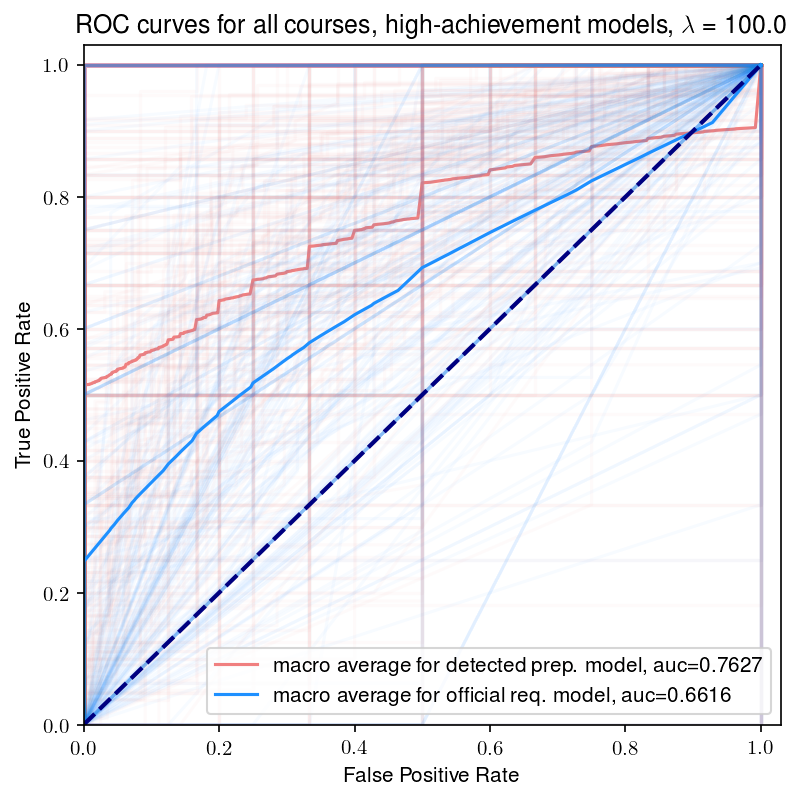

CPU times: user 42.8 s, sys: 2min 21s, total: 3min 4s
Wall time: 27.7 s


In [37]:
%%time

from concurrent.futures import ThreadPoolExecutor

LETTER_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-", "NP", "W"]
PASS_GRADES = ["A+", "A", "A-", "B+", "B", "B-", "C+", "C", "C-", "D+", "D", "D-"]
HIGH_ACH_GRADES = ["A+", "A", "A-", "B+"]
BMINUS_GRADES = ["A+", "A", "A-", "B+", "B", "B-"]
COLUMN_NAMES = ["course_name", "train_score", "test_score", "dev_score", "train_groundtruth", "test_groundtruth", "dev_groundtruth", "train_size", "test_size", "dev_size", "test_precision", "test_recall", "test_f1_score", "dev_precision", "dev_recall", "dev_f1_score", "dev_fpr", "dev_tpr", "dev_threshold", "dev_auc"]
ALL_COURSES = set(raw_data["course_name"]) 

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False
x1grades_param = HIGH_ACH_GRADES
y1grades_param = HIGH_ACH_GRADES
dev = True
penalty = 'l2'
C = 0.01
random_seed = 42
solver = 'lbfgs'

PATHNAME = "high-ach"
PLOT_TITLE = "ROC curves for all courses, high-achievement models, $\lambda$ = {}".format(1/C)

limited_run = False
limit_count = 20

cache_name = HIGH_ACH_CACHE
###############################################

results_full = []
results_prereq = []
full_coefs = {}
prereq_coefs = {}

count = 0
if limited_run:
    limit = limit_count
else:
    limit = len(courselist)

executor = ThreadPoolExecutor()
for course_name in courselist:
    if course_name not in cache_name:
        continue
    executor.submit(run_predictions_with_prereqs, course_name, cache_name, results_full, results_prereq, full_coefs, 
                                 prereq_coefs, TEST_QUARTERS, gender_param, gpa_param, x1grades_param, 
                                 y1grades_param, dev, penalty, C, random_seed, solver)
    count += 1
    if limited_run:
        if count == limit_count:
            break
executor.shutdown()
            
if limited_run:
    PATHNAME = PATHNAME + "_limited" + str(limit_count)
    
if dev:
    plot_roc(results_full, results_prereq, PATHNAME, PLOT_TITLE)

results_full_df = pd.DataFrame(results_full, columns = COLUMN_NAMES)
results_prereq_df = pd.DataFrame(results_prereq, columns = COLUMN_NAMES)
full_coefs_df = pd.DataFrame.from_dict(full_coefs, orient='index')
prereq_coefs_df = pd.DataFrame.from_dict(prereq_coefs, orient='index')

RESULTS_FULL_PATH_CSV = "../results/" + PATHNAME + "_full.csv"
RESULTS_PREREQ_PATH_CSV = "../results/" + PATHNAME + "_prereq.csv"
COEFS_FULL_PATH_CSV = "../results/" + PATHNAME + "_coefs_full.csv"
COEFS_PREREQ_PATH_CSV = "../results/" + PATHNAME + "_coefs_prereq.csv"
results_full_df.to_csv(RESULTS_FULL_PATH_CSV)
results_prereq_df.to_csv(RESULTS_PREREQ_PATH_CSV)
full_coefs_df.to_csv(COEFS_FULL_PATH_CSV)
prereq_coefs_df.to_csv(COEFS_PREREQ_PATH_CSV)

# # feather currently doesn't work for some reason
# RESULTS_FULL_PATH = "../results/" + PATHNAME + "_full.fthr"
# RESULTS_PREREQ_PATH = "../results/" + PATHNAME + "_prereq.fthr"
# results_full_df.to_feather(RESULTS_FULL_PATH)
# results_prereq_df.to_feather(RESULTS_PREREQ_PATH)

In [34]:
full_coefs_df_na = full_coefs_df.fillna(0)
prereq_coefs_df_na = prereq_coefs_df.fillna(0)
nonzero_full = list(full_coefs_df_na.astype(bool).sum(axis=1))
nonzero_prereq = list(prereq_coefs_df_na.astype(bool).sum(axis=1))
nonzeros = {
    'detected prep.': sum(nonzero_full) / len(nonzero_full),
    'official req.': sum(nonzero_prereq) / len(nonzero_prereq)
}
print("Number of nonzero coefficients for " + PATHNAME)
print(nonzeros)

Number of nonzero coefficients for high-ach
{'detected prep.': 149.93167701863354, 'official req.': 2.015625}


# LAS 2020 WIP models

## "baseline", unregularized with pass/fail

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False
x1grades_param = PASS_GRADES
y1grades_param = PASS_GRADES
dev = True
penalty = 'none'
C = 0.01
random_seed = 42
solver = 'lbfgs'

PATHNAME = "baseline"
PLOT_TITLE = "ROC curves for all courses, baseline models, unregularized"

limited_run = False
limit_count = 20

cache_name = PASS_CACHE
###############################################

## "high-ach", regularization (L2, C = 0.01) with high-ach

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False
x1grades_param = HIGH_ACH_GRADES
y1grades_param = HIGH_ACH_GRADES
dev = True
penalty = 'l2'
C = 0.01
random_seed = 42
solver = 'lbfgs'

PATHNAME = "high-ach"
PLOT_TITLE = "ROC curves for all courses, high-achievement models, $\lambda$ = {}".format(1/C)

limited_run = False
limit_count = 20

cache_name = HIGH_ACH_CACHE
###############################################

## "lasso", regularization (L1, C = 0.25) with high-ach

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False
x1grades_param = HIGH_ACH_GRADES
y1grades_param = HIGH_ACH_GRADES
dev = True
penalty = 'l1'
C = 0.25
random_seed = 42
solver = 'liblinear'

PATHNAME = "lasso"
PLOT_TITLE = "ROC curves for all courses, LASSO models, $\lambda$ = {:.1f}".format(1/C)

limited_run = False
limit_count = 20

cache_name = HIGH_ACH_CACHE
###############################################


# models run:

## 2020-05-22 "absolute_baseline", unregularized pass-pass

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = PASS_GRADES
y1grades_param = PASS_GRADES
dev = True
penalty = 'none'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "absolute_baseline"
PLOT_TITLE = "ROC curve for all courses, baseline model"

limited_run = False
limit_count = 20
###############################################

## 2020-05-22 "success_initial", default regularization (L2, C=1.0) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_initial"
PLOT_TITLE = "ROC curve for all courses, initial \"success\" model"

limited_run = False
limit_count = 20
###############################################

## 2020-05-22 "success_lasso", L1 regularization C=0.1 with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = False # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l1'
C = 0.1
random_seed = 42
solver = 'liblinear'

PATHNAME = "success_lasso"
PLOT_TITLE = "ROC curve for all courses, \"success\" model with LASSO"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_gpa", default regularization (L2, C=1.0) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = True # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_gpa"
PLOT_TITLE = "ROC curve for all courses, initial \"success\" model with GPA"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_lasso_gpa", L1 regularization C=0.1 with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = False
gpa_param = True # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l1'
C = 0.1
random_seed = 42
solver = 'liblinear'

PATHNAME = "success_lasso_gpa"
PLOT_TITLE = "ROC curve for all courses, \"success\" model with LASSO"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_gpa_gender", default regularization (L2, C=1.0) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = True
gpa_param = True # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_gpa_gender"
PLOT_TITLE = "ROC curve for all courses, initial \"success\" model with GPA and Gender"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_gender", default regularization (L2, C=1.0) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = True
gpa_param = False # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 1.0
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_gender"
PLOT_TITLE = "ROC curve for all courses, initial \"success\" model with Gender"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_lasso_gpa_gender", L1 regularization C=0.1 with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = True
gpa_param = True # currently crashes if set to True
#x1grades_param = SUCCESS_GRADES
#y1grades_param = SUCCESS_GRADES
#dev = True
penalty = 'l1'
C = 0.1
#random_seed = 42
solver = 'liblinear'

PATHNAME = "success_lasso_gpa_gender"
PLOT_TITLE = "ROC curve for all courses, \"success\" model with LASSO using GPA and Gender"

limited_run = False
limit_count = 20
###############################################

## 2020-05-25 "success_gender_gpa_reg", regularization (L2, C=0.01) with success-success

############# MODIFY THIS SECTION #############
courselist = ALL_COURSES

gender_param = True
gpa_param = True # currently crashes if set to True
x1grades_param = SUCCESS_GRADES
y1grades_param = SUCCESS_GRADES
dev = True
penalty = 'l2'
C = 0.1
random_seed = 42
solver = 'lbfgs'

PATHNAME = "success_gender_gpa_reg"
PLOT_TITLE = "ROC curve for all courses, regularized \"success\" model with GPA and Gender"

limited_run = False
limit_count = 20
###############################################

